<a href="https://colab.research.google.com/github/Chhaya-cloud/Time-Series-Analysis-for-Bitcoin-Price-Prediction-using-RNN-LSTM-and-GRU./blob/main/Time_Series_Analysis_for_Bitcoin_Price_Prediction_using_RNN%2C_LSTM%2C_and_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [11]:
# TensorFlow / Keras
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
except ImportError:
    print("TensorFlow not installed. Please install TensorFlow to use this code.")

In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()  # select kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"crajput","key":"080d015b5084e720852bcbc0297f64e3"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d mczielinski/bitcoin-historical-data


Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
  0% 0.00/97.7M [00:00<?, ?B/s]
100% 97.7M/97.7M [00:00<00:00, 1.14GB/s]


In [5]:
!unzip bitcoin-historical-data.zip -d bitcoin_data


Archive:  bitcoin-historical-data.zip
  inflating: bitcoin_data/btcusd_1-min_data.csv  


In [6]:
import os
os.listdir("bitcoin_data")


['btcusd_1-min_data.csv']

In [12]:
import pandas as pd

df = pd.read_csv("bitcoin_data/btcusd_1-min_data.csv")
df.head()


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [13]:
DATA_PATH = 'btcusd_1-min_data.csv' # change if file is elsewhere
OUT_DIR = 'bitcoin_project_outputs'
WINDOW = 30 # number of past days used to predict next day
MAX_DAYS = 2000 # cap number of daily points to keep runtime reasonable
EPOCHS = 30
BATCH_SIZE = 32

In [15]:
np.random.seed(42)
tf.random.set_seed(42)
cols = df.columns.tolist()

In [16]:
# detect datetime column
datetime_col = None
for c in cols:
  if 'date' in c.lower() or 'time' in c.lower():
    datetime_col = c
    break
if datetime_col is None:
  datetime_col = cols[0]

In [18]:
# parse and set index
# The datetime column is already the index and is of datetime type
df[datetime_col] = pd.to_datetime(df[datetime_col], unit='s', errors='coerce')
df = df.dropna(subset=[datetime_col]).sort_values(datetime_col).set_index(datetime_col)


# detect price column (prefer Close)
price_col = None
for c in cols:
  if c.lower() == 'close' or 'close' in c.lower():
    price_col = c
    break
if price_col is None:
  numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
  if not numeric_cols:
    raise ValueError('No numeric columns found in the CSV. Columns: {}'.format(cols))
  price_col = numeric_cols[-1]


print('Using datetime column (index):', df.index.name) # Use index name
print('Using price column:', price_col)

# 2) Resample to daily Close price (last observed minute's price per day)
daily = df[[price_col]].resample('D').agg({price_col: 'last'}).dropna()
daily.columns = ['Close']

# limit size for faster runs
if len(daily) > MAX_DAYS:
  daily = daily.tail(MAX_DAYS)


print('Daily points used:', len(daily))

Using datetime column (index): Timestamp
Using price column: Close
Daily points used: 2000


In [38]:
# 3) EDA - plots

import os
if not os.path.exists(OUT_DIR):
  os.makedirs(OUT_DIR)

plt.figure(figsize=(12,4))
daily['Close'].plot(title='Daily Close Price (Bitcoin)')
plt.ylabel('Price')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'plot_close_time_series.png')); plt.close()


# daily returns
daily['Return'] = daily['Close'].pct_change()
plt.figure(figsize=(12,3))
daily['Return'].plot(title='Daily Returns')
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'plot_daily_returns.png')); plt.close()


# moving averages
daily['MA7'] = daily['Close'].rolling(7).mean()
daily['MA30'] = daily['Close'].rolling(30).mean()
plt.figure(figsize=(12,4))
daily[['Close','MA7','MA30']].plot(figsize=(12,4))
plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR,'plot_moving_averages.png')); plt.close()

<Figure size 1200x400 with 0 Axes>

In [39]:
# 4) Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
daily_scaled = scaler.fit_transform(daily[['Close']].fillna(method='ffill'))


# sequence generation
def create_sequences(data, window=60):
  X, y = [], []
  for i in range(window, len(data)):
    X.append(data[i-window:i, 0])
    y.append(data[i, 0])
  X, y = np.array(X), np.array(y)
  X = X.reshape((X.shape[0], X.shape[1], 1))
  return X, y

# Adjust window size if it's larger than the number of data points
if len(daily_scaled) < WINDOW:
  print(f"Adjusting window size from {WINDOW} to {len(daily_scaled)} because the number of data points ({len(daily_scaled)}) is smaller than the specified window size.")
  WINDOW = len(daily_scaled)

if len(daily_scaled) < WINDOW: # This check is redundant after the adjustment above, but keeping for clarity
  print(f"Not enough daily data points ({len(daily_scaled)}) to create sequences with window size ({WINDOW}). Skipping sequence creation.")
  X, y = np.array([]), np.array([]) # Assign empty arrays if not enough data
else:
  X, y = create_sequences(daily_scaled, WINDOW)

/tmp/ipython-input-1041391553.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_scaled = scaler.fit_transform(daily[['Close']].fillna(method='ffill'))


In [40]:
# train/validation split (time-based)
split_idx = int(len(X) * 0.8)
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]


print('Train samples:', len(X_train), 'Validation samples:', len(X_val))

Train samples: 1576 Validation samples: 394


In [41]:
# 5) Model builders


def build_rnn(input_shape):
  model = Sequential([SimpleRNN(50, input_shape=input_shape), Dense(1)])
  model.compile(optimizer='adam', loss='mse')
  return model


def build_lstm(input_shape):
  model = Sequential([LSTM(64, input_shape=input_shape), Dropout(0.2), Dense(1)])
  model.compile(optimizer='adam', loss='mse')
  return model


def build_gru(input_shape):
  model = Sequential([GRU(64, return_sequences=True, input_shape=input_shape), GRU(32), Dropout(0.2), Dense(1)])
  model.compile(optimizer='adam', loss='mse')
  return model


es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [42]:
# 6) Train models (small epochs recommended for quick runs)
results = {}


def evaluate_and_save(model, name, X_val, y_val, scaler, out_dir):
  pred = model.predict(X_val)
  pred_inv = scaler.inverse_transform(pred)
  y_inv = scaler.inverse_transform(y_val.reshape(-1,1))
  rmse = np.sqrt(mean_squared_error(y_inv, pred_inv))
  mae = mean_absolute_error(y_inv, pred_inv)
  # save prediction plot
  import matplotlib.pyplot as plt
  plt.figure(figsize=(10,4))
  plt.plot(y_inv, label='Actual')
  plt.plot(pred_inv, label='Predicted')
  plt.title(f'Actual vs Predicted - {name}')
  plt.legend()
  plt.tight_layout(); plt.savefig(os.path.join(out_dir, f'pred_vs_actual_{name}.png')); plt.close()
  return {'rmse': float(rmse), 'mae': float(mae)}


# Train SimpleRNN
rnn = build_rnn((X_train.shape[1], X_train.shape[2]))
rnn_history = rnn.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es, rlr])
results['RNN'] = evaluate_and_save(rnn, 'RNN', X_val, y_val, scaler, OUT_DIR)
rnn.save(os.path.join(OUT_DIR,'model_rnn.h5'))


# Train LSTM
lstm = build_lstm((X_train.shape[1], X_train.shape[2]))
lstm_history = lstm.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es, rlr])
results['LSTM'] = evaluate_and_save(lstm, 'LSTM', X_val, y_val, scaler, OUT_DIR)
lstm.save(os.path.join(OUT_DIR,'model_lstm.h5'))


# Train GRU
gru = build_gru((X_train.shape[1], X_train.shape[2]))
gru_history = gru.fit(X_train, y_train, validation_data=(X_val,y_val), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[es, rlr])
results['GRU'] = evaluate_and_save(gru, 'GRU', X_val, y_val, scaler, OUT_DIR)
gru.save(os.path.join(OUT_DIR,'model_gru.h5'))


# Save training loss curves and results summary
for name, hist in [('RNN', rnn_history), ('LSTM', lstm_history), ('GRU', gru_history)]:
  plt.figure(figsize=(8,4))
  plt.plot(hist.history['loss'], label='train_loss')
  plt.plot(hist.history['val_loss'], label='val_loss')
  plt.title(f'{name} Loss')
  plt.legend()
  plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, f'loss_{name.lower()}.png')); plt.close()


summary = {
'rows_daily': len(daily),
'train_samples': int(len(X_train)),
'val_samples': int(len(X_val)),
'metrics': results
}
with open(os.path.join(OUT_DIR, 'summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)


print('Done. Results saved in', OUT_DIR)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0038 - val_loss: 0.0069 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5696e-04 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1890e-04 - val_loss: 0.0045 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.3576e-04 - val_loss: 0.0040 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1845e-04 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9813e-04 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8855e-04 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8413e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8118e-04 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0191 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0014 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.6669e-04 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - val_loss: 0.0012 - learning_rate: 5.0000e-04
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.2438e-04 - val_loss: 0.0018 - learning_rate: 5.0000e-04
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.0870e-04 - val_loss: 0.0013 - learning_rate: 5.0000e-04
Ep

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 0.0181 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0012 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0012 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0012 - val_loss: 8.9023e-04 - learning_rate: 0.0010
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0011 - val_loss: 9.8768e-04 - learning_rate: 0.0010
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 8.1224e-04 - val_loss: 9.2053e-04 - learning_rate: 0.0010
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.5004e-04 - val_loss: 9.0496e-04 - learning_rate: 0.0010
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 9.2683e-04 - val_loss: 4.9284e-04 - learning_rate: 5.0000e-04
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 9.1475e-04 - val_loss: 0.0011 - learning_rat

Done. Results saved in bitcoin_project_outputs


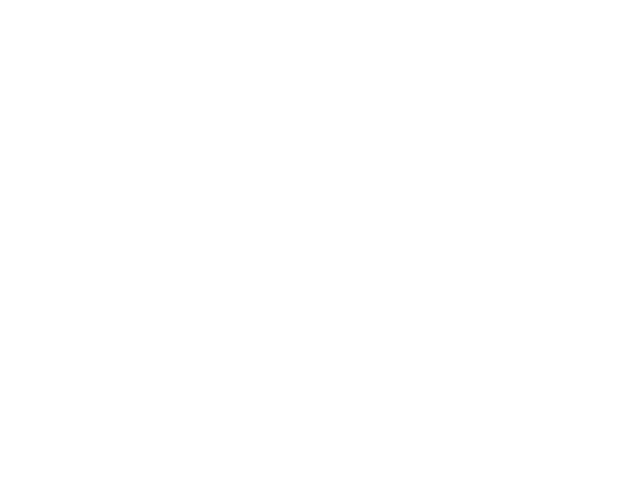

In [43]:
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Example after saving
plt.savefig(f"{OUT_DIR}/plot_close_time_series.png")
plt.close()

# ✅ Display inline in notebook
display(Image(filename=f"{OUT_DIR}/plot_close_time_series.png"))

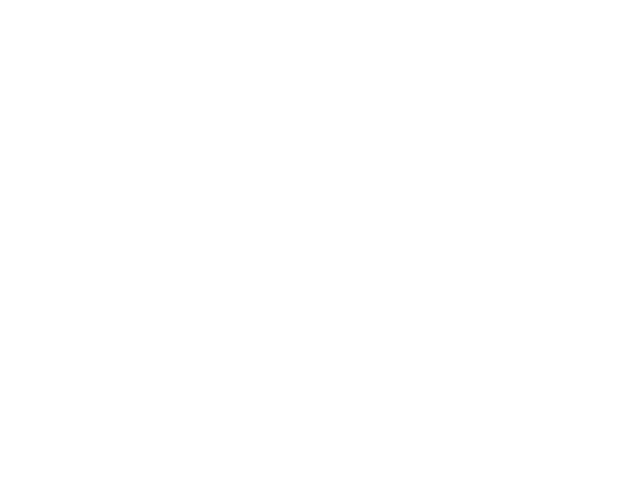

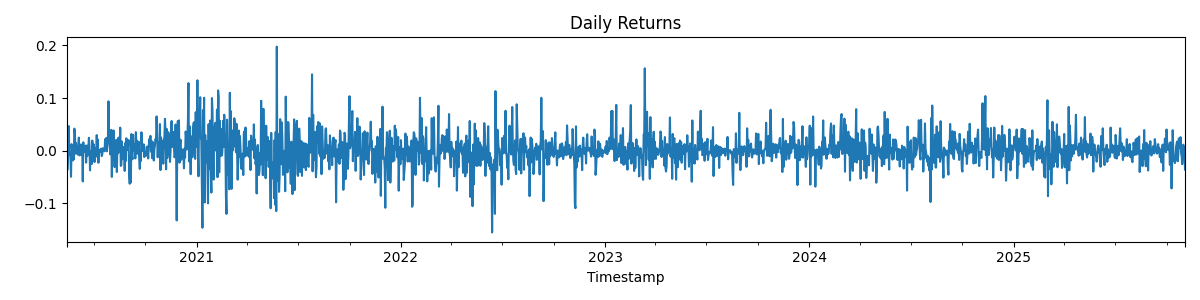

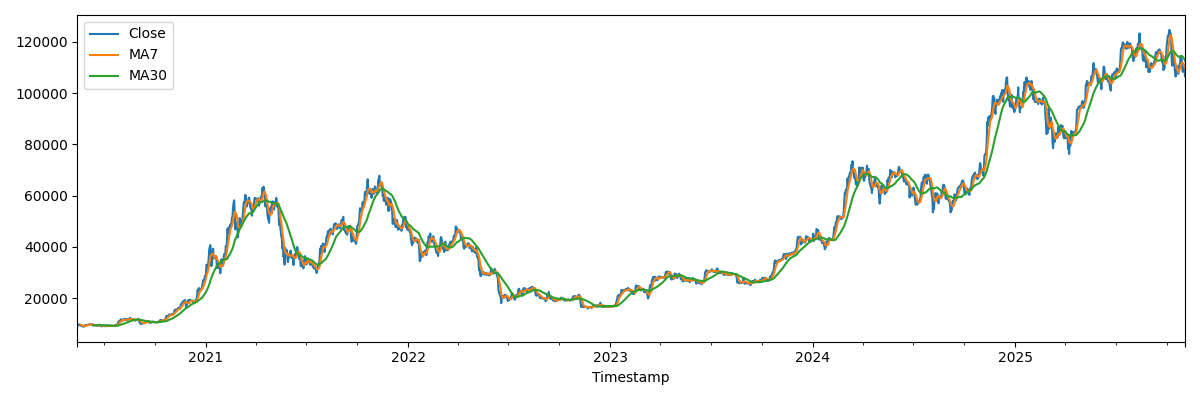

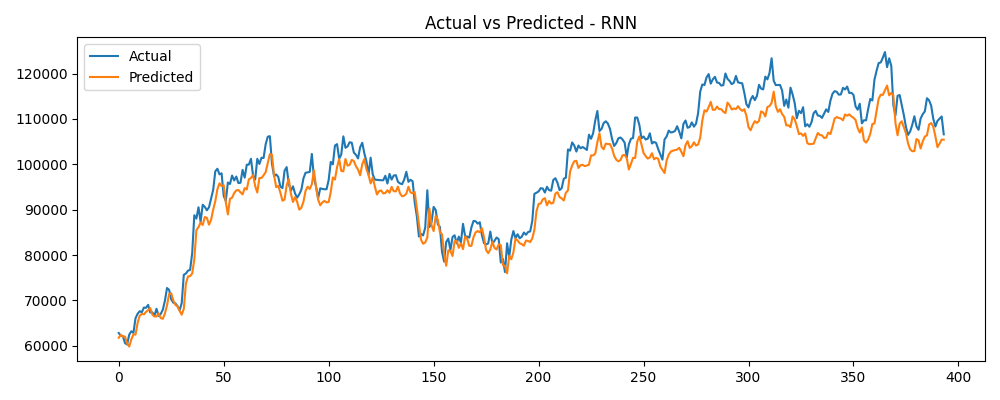

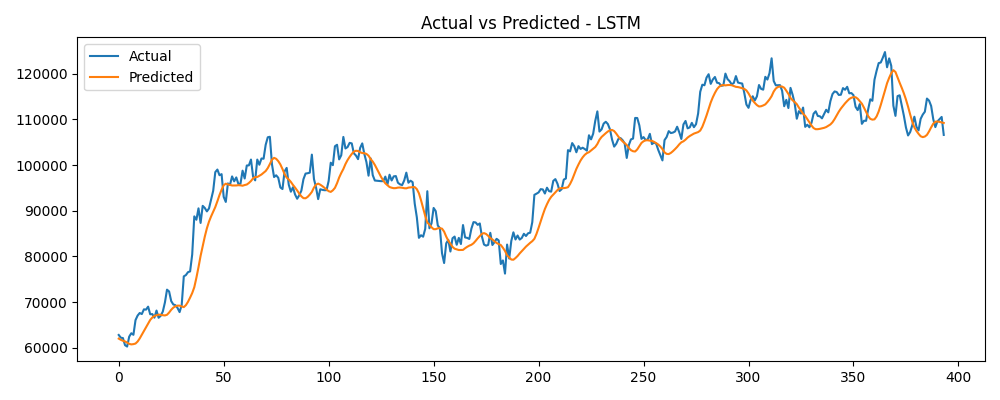

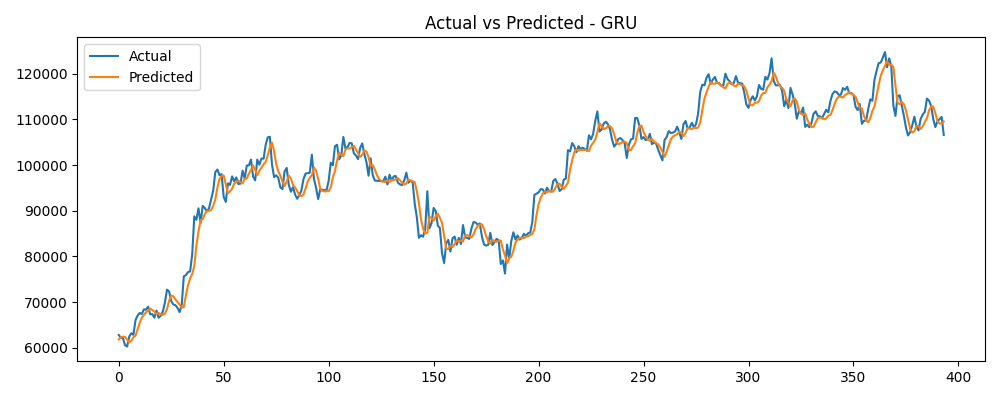

In [44]:
plots = [
    "plot_close_time_series.png",
    "plot_daily_returns.png",
    "plot_moving_averages.png",
    "pred_vs_actual_RNN.png",
    "pred_vs_actual_LSTM.png",
    "pred_vs_actual_GRU.png"
]

for p in plots:
    display(Image(filename=f"{OUT_DIR}/{p}"))

In [37]:
import json
import pandas as pd

with open(f"{OUT_DIR}/summary.json", "r") as f:
    summary_data = json.load(f)

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,rows_daily,train_samples,val_samples,metrics
RNN,2000,1576,394,"{'rmse': 3132.0071384976595, 'mae': 2533.90322..."
LSTM,2000,1576,394,"{'rmse': 4066.332781562741, 'mae': 3189.519075..."
GRU,2000,1576,394,"{'rmse': 2862.2555820960415, 'mae': 2244.63751..."
